In [8]:
import numpy as np
import polars as pl
from numba import njit
import numba as nb

# Mean of n first numbers

## Pure Python

In [9]:
n = 1_000_000
def mean_of_n_firsts_numbers(n:int)->float:
    sum_of_n_firsts = 0
    for i in range(n):
        sum_of_n_firsts += i
    mean_of_n_firsts = sum_of_n_firsts/n
    return mean_of_n_firsts

In [18]:
%%time

mean_of_n_firsts_numbers(n)

CPU times: user 85.8 ms, sys: 2.94 ms, total: 88.7 ms
Wall time: 85.9 ms


499999.5

## C

In [19]:
%%bash
cd ../C_code
gcc mean_of_n_firts_numbers.c -o mean_of_n_firts_numbers
./mean_of_n_firts_numbers

Mean value is : 499999.500000 
Mean time taken: 3.253580 ms


## Numba
Numba allows to compile python code during execution (JIT) or ahead of time

In [21]:
@njit
def mean_of_n_firsts_numbers_numba(n:int)->float:
    sum_of_n_firsts = 0
    for i in range(n):
        sum_of_n_firsts += i
    mean_of_n_firsts = sum_of_n_firsts/n
    return mean_of_n_firsts
mean_of_n_firsts_numbers_numba(n)

499999.5

In [22]:
%%timeit
mean_of_n_firsts_numbers_numba

12.6 ns ± 0.919 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


# Mean of List

Let's do the same thing, but this time with a list

## Mean in Pure Python

In [10]:
lenght_of_list = n
my_list = [x for x in range(lenght_of_list)]

In [11]:
def mean_of_list_pure_python(my_list:list):
    sum_of_x = 0
    for x in my_list:
        sum_of_x += x
    return sum_of_x/len(my_list)
%timeit mean_of_list_pure_python(my_list)
print(mean_of_list_pure_python(my_list))

17.5 ms ± 290 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
499999.5


In [12]:
speeds_records = {"pure_python":17.5}

## Mean in C

Let's run the some code in C to see how it compares

In [13]:
%%bash
cd ../C_code
gcc mean.c -o mean
./mean

Mean value is : 499999.500000 
Mean time taken: 2.032610 ms


Around 4ms, C is around 8 times faster

In [14]:
speeds_records["C"] = 2.03
speeds_records["pure_python"]/speeds_records["C"]

8.620689655172415

## Mean in Numba

In [15]:
@njit()
def mean_of_list_pure_python_numba(my_list:list):
    sum_of_x = 0
    for x in range(len(my_list)):
        sum_of_x += my_list[x]
    return sum_of_x/len(my_list)
numba_list = my_list.copy()
mean_of_list_pure_python_numba(numba_list)

499999.5

In [16]:
%timeit mean_of_list_pure_python_numba(numba_list)

594 ms ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
speeds_records["unoptimized_numba"] = 594

Numba does not work efficiently when the data type mutable such as a list, a dictionary or an object. We have first to process the input to help numba interpret better how to compile the code

In [18]:
@njit()
def mean_of_list_pure_python_numba(my_list:np.array):
    return my_list.mean()
numba_list = np.array(my_list)
mean_of_list_pure_python_numba(numba_list)

499999.5

In [19]:
%timeit mean_of_list_pure_python_numba(numba_list)

548 μs ± 3.88 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
speeds_records["optimized_numba"] = 0.548


## Mean in Numpy

In [21]:
my_list_in_numpy = np.array(my_list)

In [22]:
%timeit my_list_in_numpy.mean()
my_list_in_numpy.mean()

503 μs ± 4.96 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


499999.5

In [23]:
speeds_records["numpy"] = 0.503

In [28]:
speeds_records

{'pure_python': 17.5,
 'C': 2.03,
 'unoptimized_numba': 594,
 'optimized_numba': 0.548,
 'numpy': 0.503}

In [35]:
import seaborn as sns

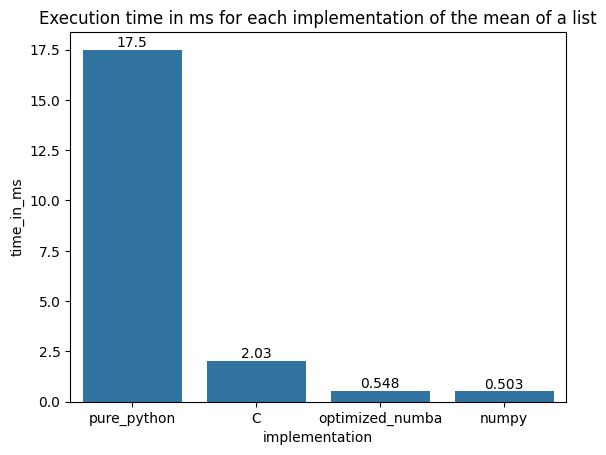

In [44]:
speed_records_df = pl.from_dict(
    {
        "implementation": [key for key in speeds_records.keys()],
        "time_in_ms": [value for value in speeds_records.values()],
    }
)
ax = sns.barplot(
    speed_records_df.filter(pl.col("implementation")!="unoptimized_numba"),
    x="implementation",
    y="time_in_ms",

)
ax.set(title="Execution time in ms for each implementation of the mean of a list")
for i in ax.containers:
    ax.bar_label(i,)

The Numpy code is 4 times faster than the C code, how is it possible?

# Multiple means

In [48]:
width = 20
my_lists = np.array([np.random.randint(0,100, n) for x in range(width)])

In [49]:
def sum_of_means_array(array2D:np.array)->float:
    sum_of_means = 0
    for i in range(len(array2D)):
        mean_of_list = array2D[i].mean()
        sum_of_means += mean_of_list
    return sum_of_means

In [53]:
%timeit sum_of_means_array(my_lists)
sum_of_means_array(my_lists)

13.6 ms ± 136 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


989.885843

In [51]:
@nb.jit(parallel=True)
def sum_of_means_array_numba(array2D:np.array)->float:
    sum_of_means = 0
    for i in nb.prange(len(array2D)):
        mean_of_list = array2D[i].mean()
        sum_of_means += mean_of_list
    return sum_of_means
sum_of_means_array_numba(my_lists)

989.8858429999998

In [52]:
%timeit sum_of_means_array_numba(my_lists)

2.77 ms ± 22 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
def sum_of_means_turbo_numpy(array2D:np.array)->float:
    return array2D.mean(axis=1).sum()
%timeit sum_of_means_turbo_numpy(my_lists)

13.4 ms ± 36.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
df = pl.DataFrame({
    f"array_{i}": array for i, array in enumerate(my_lists) 
})

In [58]:
%timeit df.mean().sum_horizontal()
df.mean().sum_horizontal()

9.7 ms ± 333 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


sum
f64
989.885843
